# Hybrid Recommendation Systems

có nhiều loại Hybrid Recommendation Systems và tôi sẽ chọn vài loại tiêu biểu

In [ ]:
import pandas as pd
import numpy as np

# Weigh Hybrid Recommendation Systems

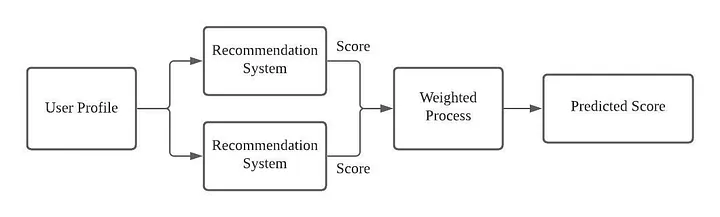

Giả sử chúng tôi đã phát triển hệ thống đề xuất dựa trên người dùng và dựa trên mặt hàng, đồng thời chúng tôi muốn xây dựng một công cụ đề xuất kết hợp có trọng số. Chúng ta có thể kết hợp các phương pháp này bằng cách gán trọng số cho đề xuất đến từ mỗi hệ thống.

Trước tiên, bạn sẽ chạy riêng các hệ thống đề xuất dựa trên người dùng và dựa trên vật phẩm của mình để tạo các đề xuất cùng với điểm số tương ứng của chúng.

Ví dụ: giả sử chúng tôi đang cố gắng giới thiệu phim cho người dùng. Hệ thống dựa trên người dùng của bạn đề xuất “Phim A” với số điểm 4,5 và “Phim B” với số điểm 4,0, trong khi hệ thống dựa trên mục đề xuất “Phim A” với số điểm 3,5 và “Phim C” với số điểm của 4,7.

Để kết hợp những đề xuất này thành một danh sách đề xuất có trọng số duy nhất, bạn sẽ nhân điểm từ mỗi hệ thống với trọng số tương ứng rồi cộng chúng lại. Trọng số có thể được xác định dựa trên hiệu suất lịch sử của từng hệ thống, chẳng hạn như trọng lượng_user_based = 0,6 và trọng lượng_item_based = 0,4. Các trọng số này cho thấy rằng chúng tôi tin tưởng các đề xuất dựa trên người dùng hơn một chút so với các đề xuất dựa trên mặt hàng.

Bây giờ, hãy tính điểm cuối cùng cho các phim:

Đối với Phim A: Final_score = 0,6 x 4,5 (dựa trên người dùng) + 0,4 x 3,5 (dựa trên mặt hàng) = 4,1

Đối với Phim B: Final_score = 0,6 x 4,0 (dựa trên người dùng) + 0,4 x 0 (không được đề xuất dựa trên mục) = 2,4

Đối với Phim C: điểm_cuối cùng = 0,6 x 0 (không được đề xuất bởi người dùng) + 0,4 x 4,7 (dựa trên mục) = 1,88

Vì vậy, danh sách phim được đề xuất cuối cùng đang giảm dần thứ tự điểm sẽ là Phim A, Phim B và Phim C

In [ ]:
!pip install opendatasets

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: phctuynl
Your Kaggle Key: ··········


100%|██████████| 228M/228M [00:01<00:00, 161MB/s]


# User-based recommend system

In [ ]:
df_rating = pd.read_csv('the-movies-dataset/ratings_small.csv')
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv')

list = ['id','genres','title']
df_movies = movies[list]


# Danh sách các giá trị 'id' bạn muốn loại bỏ
values_to_drop = ['1997-08-20', '2012-09-29', '2014-01-01']

# Xóa các hàng có giá trị 'id' trong danh sách 'values_to_drop'
df_movies = df_movies[~df_movies['id'].isin(values_to_drop)]

agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')

matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')


# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')

matrix_norm= matrix_norm.reset_index()
matrix_norm.userId = matrix_norm.userId - 1
matrix_norm= matrix_norm.set_index("userId")
user_similarity = matrix_norm.T.corr()

# Pick a user ID
picked_userid = 1

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()


# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score_users'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)


<ipython-input-77-d7ab57c19d47>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('the-movies-dataset/movies_metadata.csv')


KeyError: ignored

In [ ]:
ranked_item_score.head(len(df_movies)).reset_index()

,index,movie,movie_score
0,65,Top Hat,1.583333
1,57,The Players Club,1.555556
2,3,A Streetcar Named Desire,0.812500
3,68,Twelve Monkeys,0.812500
4,4,A Touch of Class,0.643403
...,...,...,...
68,7,Better Off Dead...,-0.973684
69,55,The Hi-Lo Country,-0.973684
70,19,End of Days,-1.416667
71,11,Bullets Over Broadway,-1.444444


In [ ]:
ranked_item_score =  anked_item_score.head(len(df_movies))

NameError: ignored

# Iterm-based recommend system

In [ ]:
df_rating = pd.read_csv('the-movies-dataset/ratings_small.csv')
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv')

from ast import literal_eval
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, type([])) else [])

movies['movieId'] = range(1, len(movies) + 1)
list = ['title','genres']
df_movies = movies[list]
df_movies.insert(0, 'movieId', range(1, len(df_movies) + 1))

df = pd.merge(df_rating, df_movies, on='movieId')
agg_ratings = df.groupby('title').agg(mean_rating = ('rating','mean'), number_of_ratings = ('rating','count')).reset_index()
agg_ratings_new = agg_ratings[agg_ratings['number_of_ratings'] > 100]


df_GT100 = pd.merge(df, agg_ratings_new[['title']], on='title', how='inner')

matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')

matrix_norm = matrix.subtract(matrix.mean(axis = 1), axis = 0)

num_columns = len(matrix_norm.columns) - 1  # Lấy số lượng cột (trừ userId)
rename_dict = {i+1: i for i in range(1, num_columns + 1)}
print(rename_dict)
matrix_norm = matrix_norm.rename(columns=rename_dict)
matrix_norm.head()
item_similarity = matrix_norm.T.corr()

def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  # Filltering unwatched of Users 2
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[picked_userid]==True]['title'].values.tolist()


  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                              .sort_values(ascending=False))\
                              .reset_index()\
                              .rename(columns={picked_userid:'rating'})
  # data frame cho biết trọng số của picked_movie với toàn bộ movie còn lại
  rating_prediction ={}

  for picked_movie in picked_userid_unwatched:
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})

    # gộp 2 lại có 2 cột rating (tức x) và similarity (tức w)
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                    right=picked_movie_similarity_score,
                                                    on='title',
                                                    how='inner')\
                                            .sort_values('similarity_score', ascending=False)[:5]

    # từ 2 cột x và w ở trên ta tính được average ( trọng số )
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                            weights=picked_userid_watched_similarity['similarity_score']), 6)
    rating_prediction[picked_movie] = predicted_rating
  import operator
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]
recommended_movie = item_based_rec(picked_userid=1, number_of_similar_items=10, number_of_recommendations = len(df_movies))


<ipython-input-84-34074aaf8206>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('the-movies-dataset/movies_metadata.csv')


{2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 121, 123

In [ ]:
recommended_movie = pd.DataFrame(recommended_movie, columns = ['movie','movie_score_iterm'])
recommended_movie

,movie,movie_score_iterm
0,The Big Sleep,0.833307
1,George of the Jungle,0.672786
2,The Country Bears,0.613402
3,Desperate Measures,0.581581
4,The Body Snatcher,0.540356
...,...,...
110,Jönssonligan & DynamitHarry,-0.492863
111,The Wooden Man's Bride,-0.500939
112,Glory,-0.624156
113,Top Hat,-0.681372


In [ ]:
df = pd.merge(item_score, recommended_movie, on='movie', how='inner')
df

,movie,movie_score,movie_score_iterm
0,11'09''01 - September 11,0.431771,-0.020221
1,A Midnight Clear,0.431771,-0.315093
2,A Perfect Candidate,0.546491,0.027566
3,A Streetcar Named Desire,0.812500,-0.180119
4,A Touch of Class,0.643403,0.050268
...,...,...,...
68,Twelve Monkeys,0.812500,0.168706
69,Used Cars,-0.059896,0.456396
70,Wonderland,-0.552083,-0.041458
71,Written on the Wind,-0.203125,0.026136


tùy thuộc hệ số u và i  để đề xuất bộ phim theo ý muốn

u là hệ số đề xuất theo người dùng (user)

i là hệ số đề xuất theo vật phẩm (item)

In [ ]:
u = 0.6
i = 1 - u

In [ ]:
df['final_score'] = df['movie_score']*u + df['movie_score_iterm']*i

In [ ]:
df.sort_values(by='final_score', ascending = False)

,movie,movie_score,movie_score_iterm,final_score
57,The Players Club,1.555556,0.527750,1.144433
65,Top Hat,1.583333,-0.681372,0.677451
68,Twelve Monkeys,0.812500,0.168706,0.554982
24,Groundhog Day,0.546491,0.525180,0.537967
34,Ménage,0.555556,0.460727,0.517624
...,...,...,...,...
56,The Nutty Professor,-1.473684,0.460884,-0.699857
55,The Hi-Lo Country,-0.973684,-0.306144,-0.706668
19,End of Days,-1.416667,0.020008,-0.841997
11,Bullets Over Broadway,-1.444444,0.055912,-0.844302
